In [2]:
import torch
import tensorflow as tf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# set device
torch.cuda.set_device(0)
device

In [3]:
import numpy as np
import pandas as pd
import pickle
import random
seed = 23
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
tf.random.set_seed(seed)

In [4]:
with open('./data/2450.pkl', 'rb') as f:
    df_20 = pickle.load(f)
df_20.reset_index(inplace=True)

In [5]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1').to(device)

c:\Users\PC\miniconda3\envs\cuda_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
df_20['question'].unique()

array(['What is the purpose of the Introduction to Machine Learning and Data Mining Lecture notes?',
       'What is the size of the data matrix X?',
       'What is the difference between the dependent variable y in regression and classification?',
       ...,
       'Who are the authors of the article "Cluster ensembles—a knowledge reuse framework for combining multiple partitions" and in which journal was it published?',
       'What is the name of the book published by Addison-Wesley in 2013 and what is its ISBN?',
       'Who wrote the article "On the early history of the singular value decomposition" and in which journal was it published?'],
      dtype=object)

In [5]:
# context_embeddings = {ctx: model.encode(ctx) for ctx in df_20['context'].unique()}
# question_embeddings = {q: model.encode(q) for q in df_20['question'].unique()}
# with open('./Embeddings/2450_context_embeddings_1000.pkl', 'wb') as f:
#     f.write(pickle.dumps(context_embeddings))
# with open('./Embeddings/2450_question_embeddings.pkl', 'wb') as f:
#     f.write(pickle.dumps(question_embeddings))
with open('./Embeddings/2450_context_embeddings_1000.pkl', 'rb') as f:
    context_embeddings = pickle.loads(f.read())
with open('./Embeddings/2450_question_embeddings.pkl', 'rb') as f:
    question_embeddings = pickle.loads(f.read())

In [7]:
from collections import defaultdict

is_added = defaultdict(lambda: 0)

contexts = df_20['context'].unique()
data = []

for i,row in df_20.iterrows():
    if is_added[row['question']]:
        continue

    dft = pd.DataFrame(columns=['context', 'question', 'label'])
    dft['context'] = contexts
    dft['question'] = row['question']
    dft['label'] = 0

    #dft.loc[dft['context']==row['context'],'label'] = 1

    for ctx in df_20.loc[df_20['question'] == row['question'],'context']:
        # if int(dft.loc[dft['context']==ctx,'label']) == 1:
        #     print("AASASASSASAS")
        dft.loc[dft['context']==ctx,'label'] = 1

    data.append(dft)

    is_added[row['question']] = 1
df = pd.concat(data, ignore_index=True)
sum(df['label'])

3355

# Models

## Preparing data

In [8]:
n_test_q = int(0.25*len(df['question'].unique()))
test_q = np.random.choice(df['question'].unique(), n_test_q, replace=False)

n_test_ctx = int(0.25*len(df['context'].unique()))
test_ctx = np.random.choice(df['context'].unique(), n_test_ctx, replace=False)

df_test = df.loc[df['question'].isin(test_q)].loc[df['context'].isin(test_ctx)]
df_test.reset_index(inplace=True, drop=True)
df_train = df.loc[~df['question'].isin(test_q)].loc[~df['context'].isin(test_ctx)]
df_train.reset_index(inplace=True, drop=True)

df_test_all_ctx = df.loc[df['question'].isin(test_q)]
df_test_all_ctx.reset_index(inplace=True, drop=True)
df_train_all_ctx =  df.loc[~df['question'].isin(test_q)]
df_train_all_ctx.reset_index(inplace=True, drop=True)

In [15]:
X_train = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_train['context'].values, df_train['question'].values)])
y_train = np.array([i for i in df_train['label'].values])

X_test = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_test['context'].values, df_test['question'].values)])
y_test = np.array([i for i in df_test['label'].values])


X_train_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_train_all_ctx['context'].values, df_train_all_ctx['question'].values)])
y_train_all_ctx = np.array([i for i in df_train_all_ctx['label'].values])

X_test_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_test_all_ctx['context'].values, df_test_all_ctx['question'].values)])
y_test_all_ctx = np.array([i for i in df_test_all_ctx['label'].values])

In [16]:
idx_train = np.random.permutation(len(X_train))
X_train = X_train[idx_train]
y_train = y_train[idx_train]

idx_test = np.random.permutation(len(X_test))
X_test = X_test[idx_test]
y_test = y_test[idx_test]

idx_train_all_ctx = np.random.permutation(len(X_train_all_ctx))
X_train_all_ctx = X_train_all_ctx[idx_train_all_ctx]
y_train_all_ctx = y_train_all_ctx[idx_train_all_ctx]

idx_test_all_ctx = np.random.permutation(len(X_test_all_ctx))
X_test_all_ctx = X_test_all_ctx[idx_test_all_ctx]
y_test_all_ctx = y_test_all_ctx[idx_test_all_ctx]

In [11]:
# # Save the data
# data = {}
# data['train'] = {}
# data['train']['X'] = X_train
# data['train']['y'] = y_train
# data['test'] = {}
# data['test']['X'] = X_test
# data['test']['y'] = y_test
# data['train_all'] = {}
# data ['train_all']['X'] = X_train_all_ctx
# data ['train_all']['y'] = y_train_all_ctx
# data['test_all'] = {}
# data['test_all']['X'] = X_test_all_ctx
# data['test_all']['y'] = y_test_all_ctx

# with open('./Results/NN/2450_data_1000.pkl', 'wb') as f:
#     f.write(pickle.dumps(data))

In [12]:
# # load the data
# with open('./NN/2450_data.pkl', 'rb') as f:
#     data = pickle.loads(f.read())

# X_train, y_train = data['train']['X'], data['train']['y']
# X_test, y_test = data['test']['X'], data['test']['y']
# X_train_all_ctx, y_train_all_ctx = data['train_all']['X'], data['train_all']['y']
# X_test_all_ctx, y_test_all_ctx = data['test_all']['X'], data['test_all']['y']

### Neural Network

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
import matplotlib.pyplot as plt

In [12]:
neural_net = Sequential()
neural_net.add(Dense(768, input_dim=768*2, activation='relu'))
neural_net.add(Dense(384, activation='relu'))
#neural_net.add(Dropout(rate=0.2))
#neural_net.add(Dense(256, activation='relu'))
neural_net.add(Dense(1, activation='sigmoid'))

neural_net.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

neural_net_g = Sequential()
neural_net_g.add(Dense(768, input_dim=768*2, activation='relu'))
neural_net_g.add(Dense(384, activation='relu'))
neural_net_g.add(Dense(1, activation='sigmoid'))

neural_net_g.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


neural_net_b = Sequential()
neural_net_b.add(Dense(768, input_dim=768*2, activation='relu'))
neural_net_b.add(Dense(384, activation='relu'))
neural_net_b.add(Dense(1, activation='sigmoid'))

neural_net_b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

neural_net_gb = Sequential()
neural_net_gb.add(Dense(768, input_dim=768*2, activation='relu'))
neural_net_gb.add(Dense(384, activation='relu'))
neural_net_gb.add(Dense(1, activation='sigmoid'))

neural_net_gb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
import tensorflow as tf
class BatchBalancerSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size):
        self.x_p = x_set[y_set==1]
        self.x_n = x_set[y_set==0]
        self.batch_size = batch_size
        self.batch_size_n = batch_size//2

    def __len__(self):
        #For each n y=0 we will oversample with n y=1
        return int(np.ceil(len(self.x_n)*2 / self.batch_size))

    def __getitem__(self, idx):
        low = idx * self.batch_size_n
        # Cap upper bound at array length; the last batch may be smaller
        # if the total number of items is not a multiple of batch size.
        high = min(low + self.batch_size_n, len(self.x_n))
        batch_x = self.x_n[low:high]
        n_neg = len(batch_x)
        batch_y = [0]*n_neg
        
        x_p_idx = np.random.choice(len(self.x_p), n_neg, replace=False)
        batch_x = np.concatenate((batch_x, self.x_p[x_p_idx]))
        batch_y = np.append(batch_y, [1]*n_neg)

        return batch_x, batch_y

In [17]:
history = neural_net.fit(BatchBalancerSequence(X_train_all_ctx, y_train_all_ctx, 128), epochs=10)
neural_net.save('./Results/NN/oversample_all_ctx')

Epoch 1/10
26256/26256 [==============================] - 395s 15ms/step - loss: 0.0254 - accuracy: 0.9921
Epoch 2/10
26256/26256 [==============================] - 432s 16ms/step - loss: 0.0065 - accuracy: 0.9983
Epoch 3/10
26256/26256 [==============================] - 451s 17ms/step - loss: 0.0041 - accuracy: 0.9989
Epoch 4/10
26256/26256 [==============================] - 442s 17ms/step - loss: 0.0033 - accuracy: 0.9992
Epoch 5/10
26256/26256 [==============================] - 443s 17ms/step - loss: 0.0025 - accuracy: 0.9994
Epoch 6/10
26256/26256 [==============================] - 441s 17ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 7/10
26256/26256 [==============================] - 935s 36ms/step - loss: 0.0020 - accuracy: 0.9996
Epoch 8/10
26256/26256 [==============================] - 975s 37ms/step - loss: 0.0017 - accuracy: 0.9996
Epoch 9/10
26256/26256 [==============================] - 961s 37ms/step - loss: 0.0013 - accuracy: 0.9997
Epoch 10/10
26256/26256 [============

INFO:tensorflow:Assets written to: ./Results/NN/oversample_all_ctx\assets


INFO:tensorflow:Assets written to: ./Results/NN/oversample_all_ctx\assets


In [ ]:
neural_net = load_model('./Results/NN/oversample_all_ctx')

In [18]:
history_gen = neural_net_g.fit(BatchBalancerSequence(X_train, y_train, 128), epochs=10)
neural_net_g.save('./Results/NN/oversample_gen')

Epoch 1/10
19722/19722 [==============================] - 379s 19ms/step - loss: 0.0242 - accuracy: 0.9924
Epoch 2/10
19722/19722 [==============================] - 325s 16ms/step - loss: 0.0064 - accuracy: 0.9983
Epoch 3/10
19722/19722 [==============================] - 325s 16ms/step - loss: 0.0040 - accuracy: 0.9990
Epoch 4/10
19722/19722 [==============================] - 339s 17ms/step - loss: 0.0032 - accuracy: 0.9992
Epoch 5/10
19722/19722 [==============================] - 351s 18ms/step - loss: 0.0027 - accuracy: 0.9994
Epoch 6/10
19722/19722 [==============================] - 335s 17ms/step - loss: 0.0023 - accuracy: 0.9995
Epoch 7/10
19722/19722 [==============================] - 334s 17ms/step - loss: 0.0018 - accuracy: 0.9996
Epoch 8/10
19722/19722 [==============================] - 527s 27ms/step - loss: 0.0015 - accuracy: 0.9996
Epoch 9/10
19722/19722 [==============================] - 677s 34ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 10/10
19722/19722 [============

INFO:tensorflow:Assets written to: ./Results/NN/oversample_gen\assets


INFO:tensorflow:Assets written to: ./Results/NN/oversample_gen\assets


In [9]:
neural_net_g = load_model('./Results/NN/oversample_gen')

In [19]:
history_basic = neural_net_b.fit(X_train_all_ctx, y_train_all_ctx, batch_size=128, epochs=10)
neural_net_b.save('./Results/NN/basic_all_ctx')

Epoch 1/10
13148/13148 [==============================] - 235s 18ms/step - loss: 0.0108 - accuracy: 0.9985
Epoch 2/10
13148/13148 [==============================] - 253s 19ms/step - loss: 0.0086 - accuracy: 0.9985
Epoch 3/10
13148/13148 [==============================] - 243s 18ms/step - loss: 0.0075 - accuracy: 0.9985
Epoch 4/10
13148/13148 [==============================] - 233s 18ms/step - loss: 0.0067 - accuracy: 0.9985
Epoch 5/10
13148/13148 [==============================] - 234s 18ms/step - loss: 0.0061 - accuracy: 0.9985
Epoch 6/10
13148/13148 [==============================] - 219s 17ms/step - loss: 0.0056 - accuracy: 0.9985
Epoch 7/10
13148/13148 [==============================] - 230s 17ms/step - loss: 0.0051 - accuracy: 0.9985
Epoch 8/10
13148/13148 [==============================] - 219s 17ms/step - loss: 0.0046 - accuracy: 0.9986
Epoch 9/10
13148/13148 [==============================] - 219s 17ms/step - loss: 0.0042 - accuracy: 0.9986
Epoch 10/10
13148/13148 [============

INFO:tensorflow:Assets written to: ./Results/NN/basic_all_ctx\assets


INFO:tensorflow:Assets written to: ./Results/NN/basic_all_ctx\assets


In [10]:
neural_net_b = load_model('./Results/NN/basic_all_ctx')

In [20]:
history_gen_basic = neural_net_gb.fit(X_train, y_train, batch_size=128, epochs=10)
neural_net_gb.save('./Results/NN/basic_gen')

Epoch 1/10
9876/9876 [==============================] - 204s 21ms/step - loss: 0.0110 - accuracy: 0.9984
Epoch 2/10
9876/9876 [==============================] - 168s 17ms/step - loss: 0.0088 - accuracy: 0.9985
Epoch 3/10
9876/9876 [==============================] - 166s 17ms/step - loss: 0.0078 - accuracy: 0.9985
Epoch 4/10
9876/9876 [==============================] - 165s 17ms/step - loss: 0.0070 - accuracy: 0.9985
Epoch 5/10
9876/9876 [==============================] - 164s 17ms/step - loss: 0.0063 - accuracy: 0.9985
Epoch 6/10
9876/9876 [==============================] - 165s 17ms/step - loss: 0.0057 - accuracy: 0.9985
Epoch 7/10
9876/9876 [==============================] - 178s 18ms/step - loss: 0.0052 - accuracy: 0.9986
Epoch 8/10
9876/9876 [==============================] - 166s 17ms/step - loss: 0.0047 - accuracy: 0.9986
Epoch 9/10
9876/9876 [==============================] - 165s 17ms/step - loss: 0.0043 - accuracy: 0.9987
Epoch 10/10
9876/9876 [==============================] 

INFO:tensorflow:Assets written to: ./Results/NN/basic_gen\assets


INFO:tensorflow:Assets written to: ./Results/NN/basic_gen\assets


In [11]:
neural_net_gb = load_model('./Results/NN/basic_gen')

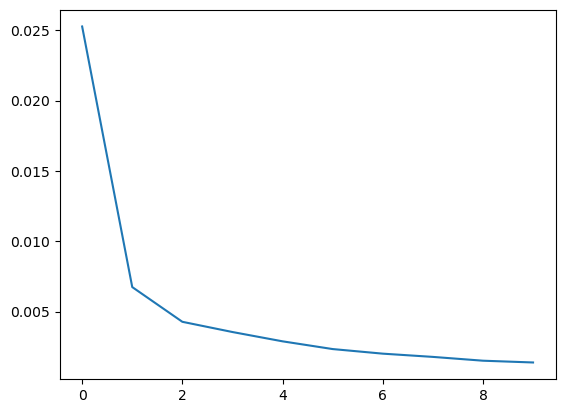

In [24]:
plt.plot(history.history['loss'])

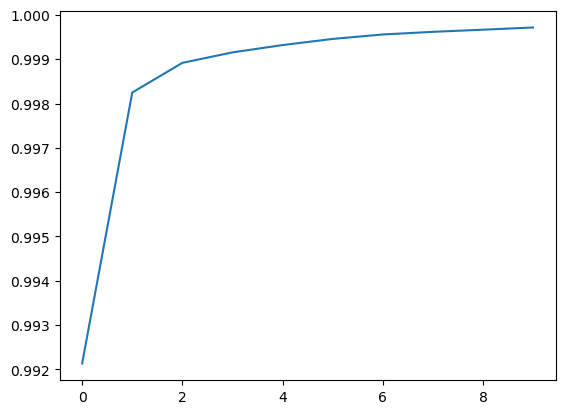

In [25]:
plt.plot(history.history['accuracy'])

#### Croos validation

In [16]:
neural_net1 = Sequential()
neural_net1.add(Dense(768, input_dim=768*2, activation='relu'))
neural_net1.add(Dense(768/2, activation='relu'))
neural_net1.add(Dense(1, activation='sigmoid'))
neural_net1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
neural_net1.cuda()

neural_net2 = Sequential()
neural_net2.add(Dense(768*3, input_dim=768*2, activation='relu'))
neural_net2.add(Dense(768*3/2, activation='relu'))
neural_net2.add(Dense(1, activation='sigmoid'))
neural_net2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

neural_net3 = Sequential()
neural_net3.add(Dense(768, input_dim=768*2, activation='relu'))
neural_net3.add(Dense(768+768/2, activation='relu'))
neural_net3.add(Dense(1, activation='sigmoid'))
neural_net3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

AttributeError: 'Sequential' object has no attribute 'cuda'

In [10]:
X_all = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df['context'].values, df['question'].values)])
y_all = np.array([i for i in df['label'].values])

q_u = df['question'].unique()

In [13]:
from sklearn import model_selection
K = 5
CV = model_selection.KFold(n_splits=K, shuffle=True, random_state=42)
k = 0
errors = np.empty((K,3))
acc = np.empty((K,3))

for train_idx, test_idx in CV.split(q_u):
    print('Cross-validation fold: {0}/{1}'.format(k+1, K))

    q_train = q_u[train_idx]
    q_test = q_u[test_idx]

    df_ques_train = df[df['question'].isin(q_train)]

    X_train_cv = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_ques_train['context'].values, df_ques_train['question'].values)])
    y_train_cv = np.array([i for i in df_ques_train['label'].values])

    df_ques_test = df[df['question'].isin(q_test)]
    X_test_cv = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_ques_test['context'].values, df_ques_test['question'].values)])
    y_test_cv = np.array([i for i in df_ques_test['label'].values])

    neural_net1.fit(BatchBalancerSequence(X_train_cv, y_train_cv, 128), epochs=10)
    eval1 = neural_net1.evaluate(X_test_cv, y_test_cv)
    errors[k, 0], acc[k, 0] = eval1[0], eval1[1]
    neural_net2.fit(BatchBalancerSequence(X_train_cv, y_train_cv, 128), epochs=10)
    eval2 = neural_net2.evaluate(X_test_cv, y_test_cv)
    errors[k, 1], acc[k, 1] = eval2[0], eval2[1]
    neural_net3.fit(BatchBalancerSequence(X_train_cv, y_train_cv, 128), epochs=10)
    eval3 = neural_net3.evaluate(X_test_cv, y_test_cv)
    errors[k, 2], acc[k, 2] = eval3[0], eval3[1]
    
    k += 1

Cross-validation fold: 1/5
Epoch 1/10
28004/28004 [==============================] - 260s 9ms/step - loss: 0.0510 - accuracy: 0.9810
Epoch 2/10
28004/28004 [==============================] - 252s 9ms/step - loss: 0.0083 - accuracy: 0.9978
Epoch 3/10
28004/28004 [==============================] - 257s 9ms/step - loss: 0.0047 - accuracy: 0.9988
Epoch 4/10
28004/28004 [==============================] - 249s 9ms/step - loss: 0.0032 - accuracy: 0.9992
Epoch 5/10
28004/28004 [==============================] - 250s 9ms/step - loss: 0.0024 - accuracy: 0.9994
Epoch 6/10
28004/28004 [==============================] - 247s 9ms/step - loss: 0.0019 - accuracy: 0.9995
Epoch 7/10
28004/28004 [==============================] - 249s 9ms/step - loss: 0.0017 - accuracy: 0.9996
Epoch 8/10
28004/28004 [==============================] - 252s 9ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 9/10
28004/28004 [==============================] - 252s 9ms/step - loss: 0.0013 - accuracy: 0.9997
Epoch 10/10
14029/1

KeyboardInterrupt: 

In [ ]:
with open('./data/nn_errors.pkl', 'wb') as f:
    f.write(pickle.dumps(errors))
with open('./data/nn_acc.pkl', 'wb') as f:
    f.write(pickle.dumps(acc))

# with open('./data/nn_acc.pkl', 'rb') as f:
#     acc = pickle.loads(f.read())
# with open('./data/nn_errors.pkl', 'rb') as f:
#     errors = pickle.loads(f.read())

In [ ]:
errors

array([[6.86854944e-002, 7.59169906e-002, 5.24166562e-002],
       [7.01776939e-003, 7.02429237e-003, 1.26838032e-002],
       [2.48478190e-003, 3.16644879e-003, 6.08132966e-003],
       [2.25971616e-003, 1.87655864e-003, 4.12425771e-003],
       [            nan, 3.51274184e-315, 4.45854211e-316]])

In [ ]:
acc

array([[0.99423379, 0.99432266, 0.99301934],
       [0.99860781, 0.99847949, 0.99751186],
       [0.99932861, 0.9991706 , 0.99882501],
       [0.99943721, 0.99957544, 0.99914098],
       [0.        , 0.        , 0.        ]])

In [ ]:
errors = errors[:4]
acc = acc[:4]

In [ ]:
e_gen = np.mean(errors, axis=0)
opt_model_e = np.argmin(e_gen)
print(f"The optimal model structure is model {opt_model_e+1}, which has a test error of {e_gen[opt_model_e]}")

a_gen = np.mean(acc, axis=0)
opt_model_a = np.argmax(a_gen)
print(f"The optimal model structure is model {opt_model_a+1}, which has a test accuracy of {a_gen[opt_model_a]}")

The optimal model structure is model 3, which has a test error of 0.018826511688530445
The optimal model structure is model 1, which has a test accuracy of 0.9979018568992615


### Matrix model

In [33]:
# import tensorflow as tf
# from tqdm import tqdm

# learning_rate = 0.025
# loss_list = []

# T = tf.Variable(np.ones(X_train.shape[1]//2))

# len_train = X_train.shape[0]

# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)


# batch_size = 128
# itt = int(np.ceil(len_train/batch_size))

# n_epochs = 20

# with tqdm(total=itt*n_epochs) as pbar:
#     for _ in range(n_epochs):
#         for i in range(1,itt+1):
#             low = (i-1)*batch_size
#             high = min(i*batch_size, len_train)

#             a = X_train[low:high,:1536//2]
#             b = X_train[low:high,1536//2:]

#             y_true = y_train[low:high]
            
#             with tf.GradientTape() as tape:
#                 tape.watch(T)  # Watch the variable T for gradient computation
#                 W = tf.exp(1/2*T)
#                 y_preds = (tf.math.reduce_sum((a*W)*(b*W), axis=1))/(tf.math.reduce_euclidean_norm(a*W, axis=1)*tf.math.reduce_euclidean_norm(b*W, axis=1))
#                 loss = tf.math.reduce_mean(tf.square(y_true - y_preds))

#             gradients = tape.gradient(loss, T)
#             optimizer.apply_gradients([(gradients, T)])
#             loss_list.append(loss)
#             pbar.update(1)

100%|██████████| 44520/44520 [17:24<00:00, 42.64it/s]


In [37]:
# import tensorflow as tf
# from tqdm import tqdm

# learning_rate = 0.05
# loss_list = []

# T = tf.Variable(np.ones(X_train_all_ctx.shape[1]//2))

# len_train_n = X_train_all_ctx.shape[0]

# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)


# batch_size = 128

# n_epochs = 10

# X_train_all_ctx_p = X_train_all_ctx[y_train_all_ctx==1]
# X_train_all_ctx_n = X_train_all_ctx[y_train_all_ctx==0]

# batch_size_n = batch_size//2

# len_train_n = len(X_train_all_ctx_n)

# itt = int(np.ceil(len_train_n/batch_size_n))

# with tqdm(total=itt*n_epochs) as pbar:
#     for _ in range(n_epochs):
#         for i in range(1,itt+1):
#             low = (i-1)*batch_size_n
#             high = min(i*batch_size_n, len_train_n)

#             batch_n = X_train_all_ctx_n[low:high]

#             x_p_idx = np.random.choice(len(X_train_all_ctx_p), len(batch_n), replace=False)

#             batch_p = X_train_all_ctx_p[x_p_idx]

#             batch = np.concatenate((batch_n, batch_p))

#             a = batch[:,:1536//2]
#             b = batch[:,1536//2:]

#             y_true = [0]*len(batch_n) + [1]*len(batch_p)
            
#             with tf.GradientTape() as tape:
#                 tape.watch(T)  # Watch the variable T for gradient computation
#                 W = tf.exp(1/2*T)
#                 y_preds = (tf.math.reduce_sum((a*W)*(b*W), axis=1))/(tf.math.reduce_euclidean_norm(a*W, axis=1)*tf.math.reduce_euclidean_norm(b*W, axis=1))
#                 loss = tf.math.reduce_mean(tf.square(y_true - y_preds))

#             gradients = tape.gradient(loss, T)
#             optimizer.apply_gradients([(gradients, T)])
#             loss_list.append(loss)
#             pbar.update(1)

100%|██████████| 58980/58980 [10:18<00:00, 95.41it/s] 


In [ ]:
# # Weighted dot-product
# learning_rate = 0.2
# loss_list = []
# val_list = []

# T = tf.Variable(np.ones(X_train_all_ctx.shape[1]//2))

# len_train = X_train_all_ctx.shape[0]

# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

# batch_size = 128
# itt = int(np.ceil(len_train/batch_size))

# n_epochs = 50

# loss = tf.keras.losses.mean_squared_error

# with tqdm(total=itt*n_epochs) as pbar:
#     for _ in range(n_epochs):
#         for i in range(1,itt+1):
#             low = (i-1)*batch_size
#             high = min(i*batch_size, len_train)

#             a = X_train_all_ctx[low:high,:1536//2]
#             b = X_train_all_ctx[low:high,1536//2:]

#             y_true = y_train_all_ctx[low:high]
            
#             with tf.GradientTape() as tape:
#                 tape.watch(T)  # Watch the variable T for gradient computation
#                 W = tf.exp(T)
#                 y_preds = tf.math.reduce_sum(a*W*b, axis=1)
#                 error = loss(y_true, y_preds)

#             gradients = tape.gradient(error, T)
#             optimizer.apply_gradients([(gradients, T)])
#             loss_list.append(error.numpy())
#             pbar.update(1)

In [38]:
# loss_list_epochs = []
# for i in range(n_epochs):
#     loss_list_epochs.append(np.mean(loss_list[i*itt:(i+1)*itt]))

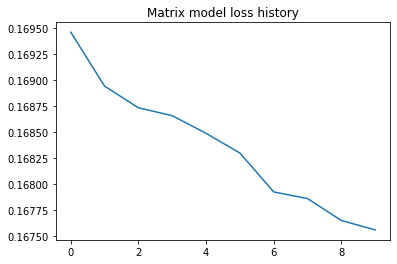

In [39]:
# plt.title("Matrix model loss history")
# plt.plot(loss_list_epochs)

## Test models

In [21]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(fp, tp, label=f'{name} AUC: {roc_auc_score(labels, predictions):.3f}', linewidth=2, **kwargs)
  plt.xlabel('False positives')
  plt.ylabel('True positives')
  plt.xlim([-0.05,1])
  plt.ylim([0,1.05])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [22]:
y_nn_preds = neural_net.predict(X_test_all_ctx)

17530/17530 [==============================] - 57s 3ms/step


In [23]:
y_nng_preds = neural_net_g.predict(X_test)

4363/4363 [==============================] - 27s 6ms/step


In [24]:
y_nnb_preds = neural_net_b.predict(X_test_all_ctx)

17530/17530 [==============================] - 92s 5ms/step


In [25]:
y_nngb_preds = neural_net_gb.predict(X_test)

4363/4363 [==============================] - 18s 4ms/step


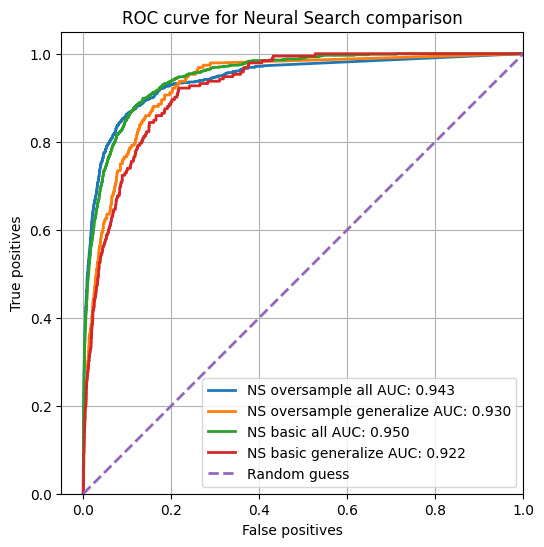

In [26]:
plt.figure(figsize=(10,6))
plot_roc("NS oversample all", y_test_all_ctx, y_nn_preds)
plot_roc("NS oversample generalize", y_test, y_nng_preds)
plot_roc("NS basic all", y_test_all_ctx, y_nnb_preds)
plot_roc("NS basic generalize", y_test, y_nngb_preds)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, label='Random guess')
plt.title("ROC curve for Neural Search comparison")
plt.legend(loc='lower right')
plt.savefig('./Results/NN/comparison.png')
plt.show()

In [20]:
# y_cosine_preds = [np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(X_test_all_ctx[:,:1536//2], X_test_all_ctx[:,1536//2:])]

In [40]:
# W = tf.exp(1/2*T).numpy()
# y_matrix_preds_batch_os = [((a*W).T@(b*W))/(np.linalg.norm(a*W)*np.linalg.norm(b*W)) for a,b in zip(X_test_all_ctx[:,:1536//2], X_test_all_ctx[:,1536//2:])]

In [ ]:
# W = tf.exp(T).numpy()
# y_weight_preds = [tf.math.reduce_sum((a*W*b), axis=1) for a,b in zip(X_test_all_ctx[:,:1536//2], X_test_all_ctx[:,1536//2:])]

In [ ]:
# y_dot_preds = [np.dot(a, b) for a,b in zip(X_test_all_ctx[:,:1536//2], X_test_all_ctx[:,1536//2:])]

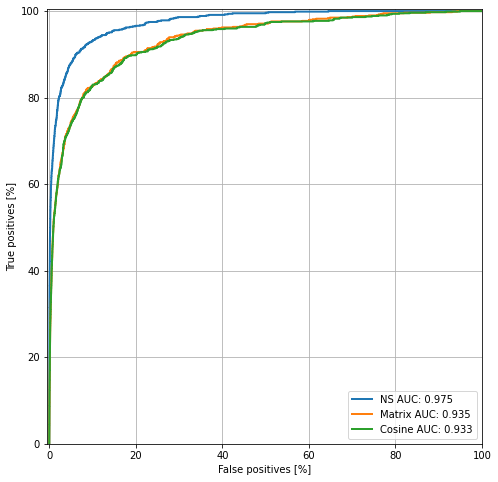

In [60]:
# plt.figure(figsize=(16,8))
# plot_roc("NS", y_test_all_ctx, y_nn_preds)
# #plot_roc("Matrix", y_test_all_ctx, y_matrix_preds)
# plot_roc("Matrix", y_test_all_ctx, y_matrix_preds_batch_os)
# plot_roc("Cosine", y_test_all_ctx, y_cosine_preds)
# plt.legend(loc='lower right')

In [47]:
# W = tf.exp(1/2*T).numpy()
# y_matrix_preds = [((a*W).T@(b*W))/(np.linalg.norm(a*W)*np.linalg.norm(b*W)) for a,b in zip(X_test[:,:1536//2], X_test[:,1536//2:])]

In [48]:
# y_cosine_preds = [np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(X_test[:,:1536//2], X_test[:,1536//2:])]

In [23]:
# roc_auc_score(y_test, y_cosine_preds)

0.9143136551147619

In [21]:
fpr, tpr, thresholds = roc_curve(y_test, y_cosine_preds, pos_label=2)
auc(fpr, tpr)

c:\Users\Lauritz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


nan

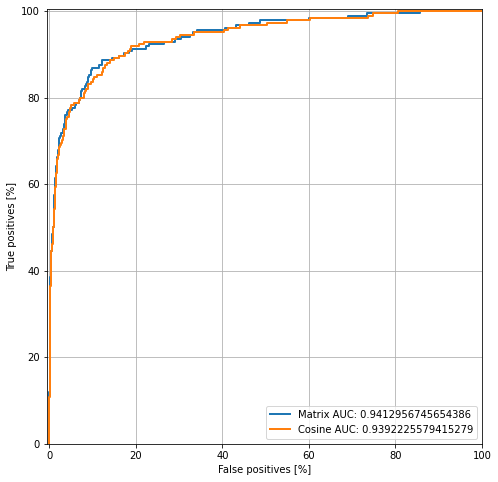

In [50]:
plt.figure(figsize=(16,8))
#plot_roc("NS", y_test, y_nn_preds)
plot_roc("Matrix", y_test, y_matrix_preds)
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')

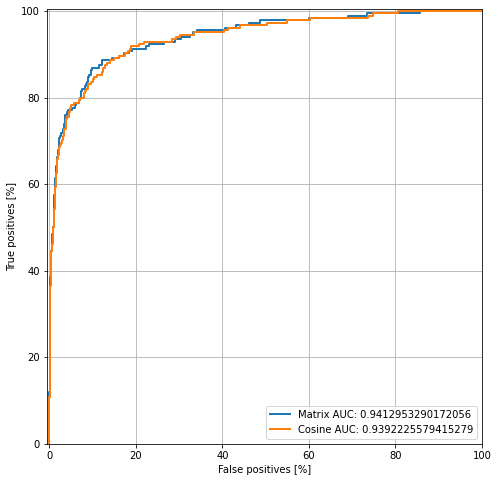

In [29]:
plt.figure(figsize=(16,8))
#plot_roc("NS", y_test, y_nn_preds)
plot_roc("Matrix", y_test, y_matrix_preds)
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')

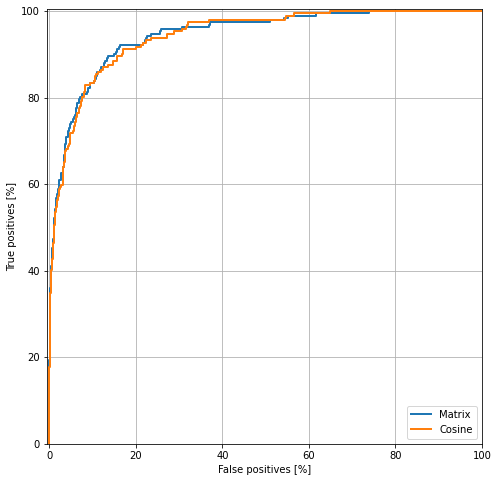

In [17]:
plt.figure(figsize=(16,8))
#plot_roc("NS", y_test, y_nn_preds)
plot_roc("Matrix", y_test, y_matrix_preds)
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')

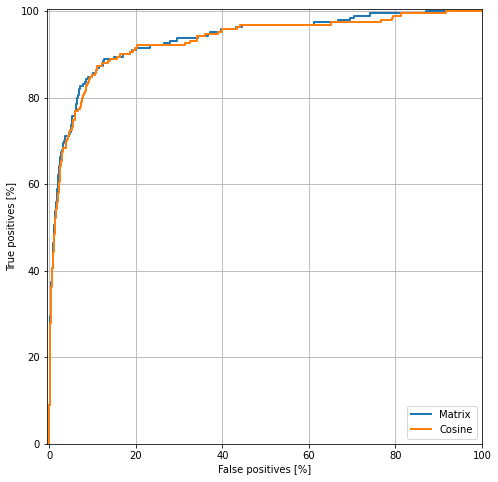

In [188]:
plt.figure(figsize=(16,8))
#plot_roc("NS", y_test, y_nn_preds)
plot_roc("Matrix", y_test, y_matrix_preds)
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')

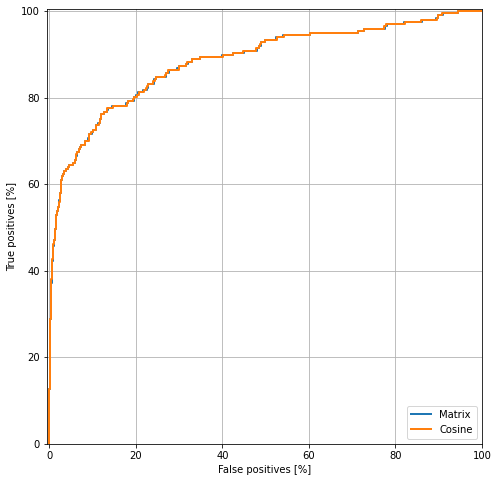

In [20]:
plt.figure(figsize=(16,8))
#plot_roc("NS", y_test, y_nn_preds)
plot_roc("Matrix", y_test, y_matrix_preds)
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')

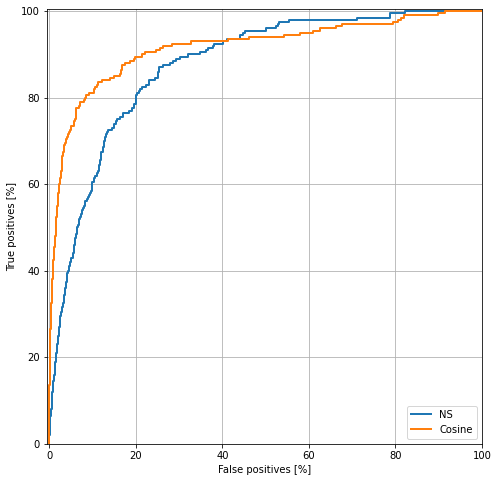

In [59]:
#plot_roc("Train", train_labels, train_predictions_baseline, color=colors[0])
plt.figure(figsize=(16,8))
plot_roc("NS", y_test, y_nn_preds.flatten())
plot_roc("Cosine", y_test, y_cosine_preds)
plt.legend(loc='lower right')